## Вариант 3
- Параметры задачи: радиусы R1, R2.
- Второй критерий: прочность 1.
- Метод многокритериальной оптимизации: 3
- Граничные условия:
- Зона А - полное закрепление.
- Зона 𝐵 - распределенное усилие, направленное по касательной в каждой точке зоны, чтобы
соответствовать "вращению" восьмиугольника по часовой стрелке.
- Минимальный размер элемента - 10 см.
- Описание детали:
- Деталь - квадрат с 4-мя одинаковыми отверстиями в форме равнобедренных прямоугольных
треугольников и одним восьмиугольным отверстием по центру. Вершины прямых углов всех отверстий 𝐴 находятся на окружности радиуса R2. Гипотенузы треугольных отверстий равны стороне восьмиугольника.

![Image of part](./Detail2.png)

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np
import scipy.optimize
import scipy.spatial
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def rotate(alpha, points=None, point=None):
    c, s = np.cos(np.radians(alpha)), np.sin(np.radians(alpha))
    mat = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    if point is not None:
        return np.array(mat.dot(point)).reshape(-1, 2)
    elif points is not None:
        return np.array([
            mat.dot(points[i]) for i in range(len(points))
        ]).reshape(-1, 2)

In [3]:
def detail_main_parts(R1, R2, L):
    border = np.array([
        rotate(
            i * 90,
            point=np.array([L/2, L/2])
        )
        for i in range(5)
    ]).reshape(-1, 2)
    
    # Найдём сторону 8угольника
    # https://ru.wikipedia.org/wiki/Правильный_восьмиугольник
    k = 1 + np.sqrt(2)
    t = 2 * R1 / k
    R1_O = t * np.sqrt(k/(k-1)) 
    
    # Построим треугольник:
    #  катет треугольника
    kat = t / np.sqrt(2)
    triangle = np.array([
        [0, 0],
        [0, -kat],
        [-kat, 0],
        [0, 0]
    ]) + [R2 / np.sqrt(2), R2 / np.sqrt(2)]
    
    
    # Построим восьмиугольник
    p = rotate(-45 / 2, point=[0, R1_O])[0]
    octagon = np.array([
        rotate(
            i * 45,
            point=p
        )
        for i in range(9)
    ]).reshape(-1, 2)
    
    return border, triangle, octagon

In [4]:
def split_border(Nodes,N,closed=False):
    points_x = np.array([])
    points_y = np.array([])
    for i in range(Nodes.shape[0]-2):
        points_x = np.append(points_x, np.linspace(Nodes[i,0], Nodes[i+1,0], int(N[i]))[:-1])
        points_y = np.append(points_y, np.linspace(Nodes[i,1], Nodes[i+1,1], int(N[i]))[:-1])
        
    if not closed:   
        points_x = np.append(points_x, np.linspace(Nodes[-2,0], Nodes[-1,0], int(N[-1])))
        points_y = np.append(points_y, np.linspace(Nodes[-2,1], Nodes[-1,1], N[-1]))
    if closed:
        points_x = np.append(points_x, np.linspace(Nodes[-2,0], Nodes[-1,0], int(N[-1]))[:-1])
        points_y = np.append(points_y, np.linspace(Nodes[-2,1], Nodes[-1,1], int(N[-1]))[:-1])
    
    
    return np.hstack((points_x.reshape(-1,1),points_y.reshape(-1,1)))

In [47]:
def show_parts(*parts, **kwargs):
    plt.figure(figsize=(14,8))
    plt.grid(True)
    plt.axis('equal')
    for part in parts:
        plt.plot(part[:,0],part[:,1], '.-', c='r')

In [48]:
def show_detail(border, triangles, octagon, inner=None):
   
    #show_parts(
    #    split_border(border,       rect_segs, closed=True),
    #    split_border(triangles[0], tri_segs, closed=True),
    #    split_border(triangles[1], tri_segs, closed=True),
    #    split_border(triangles[2], tri_segs, closed=True),
    #    split_border(triangles[3], tri_segs, closed=True),
    #    split_border(octagon,      oct_segs, closed=True)
    #)
    
    show_parts(
        border, 
        triangles[0], triangles[1], triangles[2], triangles[3],
        octagon
    )
    
    if inner is not None:
        plt.plot(inner[:,0],inner[:,1],'.')

In [49]:
def plot_contour_map(ResNodes, NodeS1, border, octagon, simplices, fixed_elems, force_elems):
    i_max = np.argmax(NodeS1)
    i_min = np.argmin(NodeS1)
    plt.figure(figsize=(15,15))
    levels = np.linspace(NodeS1[i_min], NodeS1[i_max], 12)
    handle = plt.tricontourf(ResNodes[:,0], ResNodes[:, 1], simplices, NodeS1.ravel(), cmap='jet',levels=levels)
    plt.tricontour(ResNodes[:, 0], ResNodes[:, 1], simplices, 
                  NodeS1.ravel(), colors='k', levels=levels)
    plt.plot(border[:,0],border[:,1],'r','-')
    plt.plot(octagon[:,0],octagon[:,1],'r','-')
    
    for elem in fixed_elems:
        plt.plot(ResNodes[elem,0],ResNodes[elem,1],'.k')
        #plt.text(ResNodes[elem,0],ResNodes[elem,1],'({}) {:.2f}'.format(elem,NodeS1[elem]),fontsize=12)
    
    for elem in force_elems:
        plt.plot(ResNodes[elem,0],ResNodes[elem,1],'.r')
        #plt.text(ResNodes[elem,0]-2.5,ResNodes[elem,1],'({}) {:.2f}'.format(elem,NodeS1[elem]),fontsize=12)
    
    
    plt.text(ResNodes[i_max,0], ResNodes[i_max,1], ' %.2f'%NodeS1[i_max],fontsize=20, color='white', bbox={'facecolor':'red', 'alpha':0.5, 'pad':0})
    plt.plot(ResNodes[i_max,0], ResNodes[i_max,1], '.b')
    plt.text(ResNodes[i_min,0], ResNodes[i_min,1], ' %.2f'%NodeS1[i_min],fontsize=20, color='white', bbox={'facecolor':'red', 'alpha':0.5, 'pad':0})
    plt.plot(ResNodes[i_min,0], ResNodes[i_min,1], '.r')
    
    
    cb = plt.gcf().colorbar(handle)
    cb.set_ticks(levels)
    plt.title('Поле главных напряжений в узлах, Н/см$^2$')
    plt.xlabel('X, см')
    plt.ylabel('Y, см')
    plt.axis('equal')
    plt.ylim((-80, 80))

In [50]:
def detail_border(R1, R2, L=150, segs_factor=2):
    border, triangle, octagon = detail_main_parts(R1, R2, L)
    
    triangles = np.array([
        triangle, 
        rotate(90, points=triangle), 
        rotate(180, points=triangle), 
        rotate(270, points=triangle)
    ])
    
    return border, triangles, octagon

In [51]:
def line(p1,p2,x):
    return p1[1]+(p2[1]-p1[1])*((x-p1[0])/(p2[0]-p1[0]))

In [52]:
def outside_octagon_mask(inner, octagon):
    mask1 = (inner[:,1]<octagon[0][1]) & (inner[:,1]>octagon[4][1]) & (inner[:,0]>octagon[2][0]) & (inner[:,0]<octagon[6][0])
   
    mask2 = (inner[:,1] < line(octagon[1],octagon[2],inner[:,0]))
    mask3 = (inner[:,1] < line(octagon[0],octagon[7],inner[:,0])) 
    mask4 = (inner[:,1] > line(octagon[3],octagon[4],inner[:,0]))
    mask5 = (inner[:,1] > line(octagon[5],octagon[6],inner[:,0]))

    return np.logical_not(mask1 & mask2 & mask3 & mask4 & mask5)

In [53]:
def outside_triangles_mask(inner, triangles):
    
    mask0 = np.array([np.all(p < triangles[0, 0]) and np.all(p > -triangles[0, 0]) for p in inner])
    
    octagon1 = np.array([tri[1:-1] for tri in triangles]).reshape(-1, 2)
    octagon1 = np.roll(octagon1, -1, axis=0)
    
    mask1 = outside_octagon_mask(inner, octagon1)
    
    return mask1 & mask0

In [99]:
def detail_inner(octagon, triangles, density=25, offset=5, L=150):
    X, Y = np.meshgrid(
        np.linspace(-L / 2 + offset,  L / 2 - offset, density), 
        np.linspace( L / 2 - offset, -L / 2 + offset, density)
    )  
    
    inner = np.vstack((X.ravel(), Y.ravel())).T
    
    mask1 = outside_octagon_mask(inner, octagon * 1.02)
    mask2 = outside_triangles_mask(inner, triangles)
    
    mask = mask1 & ~mask2
    
    inner = inner[mask]
    
    return inner

In [188]:
def detail(R1, R2, segs_factor=1):
    border, triangles, octagon = detail_border(R1, R2, segs_factor=20)
    inner = detail_inner(octagon, triangles, density=60, offset=2)
    
    rect_segs = np.array([17] * 4) * segs_factor
    tri_segs = np.array([4, 5, 4]) * segs_factor
    oct_segs = np.array([5] * 8)   * segs_factor
    
    border1 = split_border(border, rect_segs, closed=True)
    triangles1 = np.array([
        split_border(triangles[0], tri_segs, closed=True),
        split_border(triangles[1], tri_segs, closed=True),
        split_border(triangles[2], tri_segs, closed=True),
        split_border(triangles[3], tri_segs, closed=True)
    ])
    octagon1 = split_border(octagon, oct_segs, closed=True)
    
    Nodes = np.vstack((border1, triangles1[0], triangles1[1], triangles1[2], triangles1[3], octagon1,inner))
    
    #show_detail(border1, triangles1, octagon1, inner)
    #plt.figure(figsize=(15,15))
    #plt.plot(Nodes[:,0], Nodes[:,1], '.')
    
    return Nodes, border, triangles, octagon, inner, len(border1), len(border1) + len(triangles1[0]) * 4, len(border1) + len(triangles1[0]) * 4 + len(octagon1)

In [189]:
def triarea(a, b, c):
    ab = b - a
    ac = c - a
    return 0.5 * (ab[:,0]*ac[:,1] - ab[:,1]*ac[:,0])

In [190]:
def FEM(nodes, simplices, e, mu, t, p, fixed_elems, forced_elems):
    # расчет матрицы градиентов
    trng_vertices2 = nodes[simplices] # Пересчитаем, т.к. надо учитывать маски
    A = triarea(trng_vertices2[:,0], trng_vertices2[:,1], trng_vertices2[:,2]) # площади треугольников
    b = trng_vertices2[:, [1,2,0], 1] - trng_vertices2[:, [2, 0, 1], 1]
    c = trng_vertices2[:, [2,0,1], 0] - trng_vertices2[:, [1, 2, 0], 0]
    z = np.zeros_like(b[:,0])
    B1 = np.stack((b[:,0], z, b[:,1], z, b[:,2], z), axis=1)
    B2 = np.stack((z, c[:,0], z, c[:,1], z, c[:,2]), axis=1)
    B3 = np.stack((c[:,0], b[:,0], c[:,1], b[:,1], c[:,2], b[:,2]), axis=1)
    B = np.stack((B1, B2, B3), axis=1) # матрица градиентов
    
    # расчет глобальной матрицы жесткости
    coef = 1/(2*A)
    B *= coef.reshape(-1, 1, 1)
    D = e / (1 - mu**2)*np.array([[1,mu,0], [mu,1,0], [0,0,0.5*(1-mu)]])
    BT = np.transpose(B, axes=(0,2,1))
    Ke = np.matmul(np.matmul(BT, D), B)*t*A.reshape(-1, 1, 1)
    coords0 = simplices[:, 0].reshape(-1, 1)
    coords1 = simplices[:, 1].reshape(-1, 1)
    coords2 = simplices[:, 2].reshape(-1, 1)
    EFT = np.hstack((coords0*2, coords0*2+1, coords1*2, coords1*2+1, coords2*2, coords2*2+1))
    Nn = nodes.shape[0]
    K = np.zeros((2*Nn, 2*Nn))
    for i in range(simplices.shape[0]):
        K[EFT[i, np.newaxis].T,EFT[i]] += Ke[i]
    dof = np.hstack((fixed_elems*2, fixed_elems*2+1))
    K[dof,:] = 0
    K[:,dof] = 0
    K[dof,dof] = 1
    
    # расчет силы, действующей на элементы
    F = np.zeros(2*Nn)
    edges_L = np.sqrt(np.sum((nodes[forced_elems[1:]]-nodes[forced_elems[:-1]])**2,axis=1))
    edges_F = np.ones((len(forced_elems),)) * p / edges_L[0]

    
    forced_elems_ext = np.append(np.append(forced_elems[-1], forced_elems), forced_elems[0]) 
    vecs = np.array([ 
        (nodes[i-1] - nodes[i+1]) / np.linalg.norm(nodes[i-1] - nodes[i+1]) for i in forced_elems_ext[1: -1] 
    ])
    
    # cos
    F[forced_elems*2] += edges_F * vecs[:, 0]
    
    # sin
    F[forced_elems*2+1] += edges_F * vecs[:, 1]
    
    F[dof] = 0
    
    # расчет перемещений
    U = np.linalg.solve(K, F)
    
    # расчет напряжений и главных напряжений
    Ue = U[EFT, None] # матрица перемещений
    Eps = np.matmul(B, Ue) # тензор деформаций
    Sig = np.matmul(D, Eps) # тензор напряжений
    NodeA = np.zeros((Nn,1)) 
    NodeSig = np.zeros((Nn,3))
    for i, e in enumerate(simplices):
        NodeSig[e] += Sig[i].T*A[i]
        NodeA[e] += A[i]
    NodeSig /= NodeA
    NodeS1 = 0.5*(NodeSig[:,0]+NodeSig[:,1])+\
         np.sqrt((0.5*(NodeSig[:,0]-NodeSig[:,1]))**2+NodeSig[:,2]**2)
    
    return U, NodeS1

In [191]:
def WTF(R1, R2):
    Nodes, border, triangles, octagon, inner, forced_i_start, forced_i_end, fixed_i_end = detail(R1, R2, segs_factor=3)
    
    trng = scipy.spatial.Delaunay(Nodes)
    
    trng_vertices = Nodes[trng.simplices]
    trng_x_verices = trng_vertices[:,:,0]
    trng_y_verices = trng_vertices[:,:,1]
    trng_x_mean = np.mean(trng_x_verices,axis=1)
    trng_y_mean = np.mean(trng_y_verices,axis=1)

    trng_centers = np.hstack((trng_x_mean.reshape(-1,1),trng_y_mean.reshape(-1,1)))

    
    #masks
    mask1 = outside_octagon_mask(trng_centers, octagon) 
    mask2 = outside_triangles_mask(trng_centers, triangles)
    mask =  mask1 & ~mask2

    simplices = trng.simplices.copy()
    simplices = simplices[mask]
    
    
    # plt.figure(figsize=(14,8))
    # plt.triplot(Nodes[:,0],Nodes[:,1],simplices)
    # plt.axis('equal')
    
    # print(forced_i_start, forced_i_end)
    
    # plt.figure(figsize=(15,15))
    # plt.plot(Nodes[forced_i_start : fixed_i_end, 0], Nodes[forced_i_start : fixed_i_end, 1],'.',c='r')
    # for i, p in enumerate(Nodes[forced_i_start : fixed_i_end]):
    #     plt.text(p[0], p[1], ' %d'%i)
    # plt.axis('equal')
    # plt.grid(True)
    
    
    fixed = np.array(range(forced_i_start, forced_i_end))
    forced = np.array(range(forced_i_end, fixed_i_end))

    U, NodeS1 = FEM(Nodes, simplices, e=22e6, mu=0.31, t=1, p=1000, fixed_elems=fixed, forced_elems=forced)
    scale = 10
    ResNodes = Nodes + scale*U.reshape(-1, 2)
    plot_contour_map(ResNodes, NodeS1, border, octagon, simplices, fixed, forced)
    
    

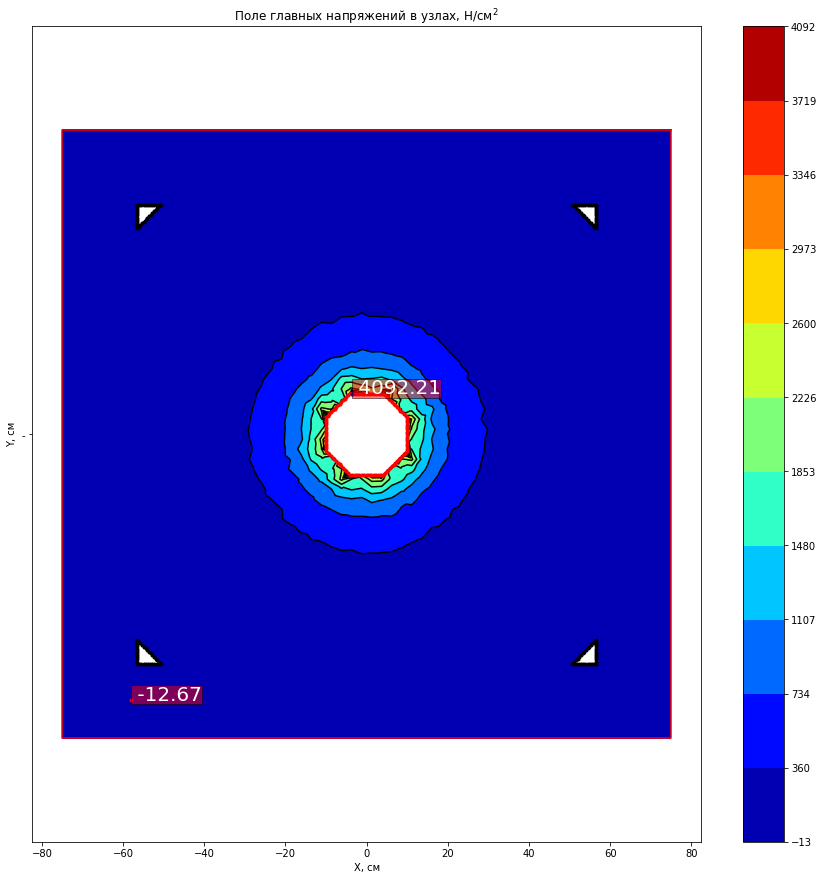

In [192]:
WTF(10, 80)